In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.5 MB/s 
     |████████████████████████████████| 1.2 MB 34.4 MB/s 
     |████████████████████████████████| 189 kB 34.5 MB/s 
     |████████████████████████████████| 48 kB 2.0 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 51 kB 204 kB/s 
     |████████████████████████████████| 558 kB 34.3 MB/s 
     |████████████████████████████████| 130 kB 25.6 MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

# About Dataset

I have created my dataset while doing IBM's computer vision course. It is three class dataset: fire, smoke and neutral. Neutral class can be considered as negative examples. It has some red background images to avoid that our classifier misclassifies red tone images as fire.

I choose this dataset because recognizing smoke and fire is difficult for humans too and I want to observe how fast.ai's black box functions performs on a difficult task like this.

In [ ]:
path = '/content/drive/MyDrive/images'

In [ ]:
fns = get_image_files(path)
fns

(#450) [Path('/content/drive/MyDrive/images/fire/fire.1.png'),Path('/content/drive/MyDrive/images/fire/fire.100.png'),Path('/content/drive/MyDrive/images/fire/fire.10.png'),Path('/content/drive/MyDrive/images/fire/fire.104.png'),Path('/content/drive/MyDrive/images/fire/fire.103.png'),Path('/content/drive/MyDrive/images/fire/fire.101.png'),Path('/content/drive/MyDrive/images/fire/fire.102.png'),Path('/content/drive/MyDrive/images/fire/fire.116.png'),Path('/content/drive/MyDrive/images/fire/fire.128.png'),Path('/content/drive/MyDrive/images/fire/fire.108.png')...]

In [ ]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = data_block.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.578692,1.086807,0.288889,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.783817,0.582825,0.177778,00:13
1,0.598802,0.487589,0.155556,00:13
2,0.475861,0.456897,0.122222,00:13
3,0.384652,0.435296,0.111111,00:13


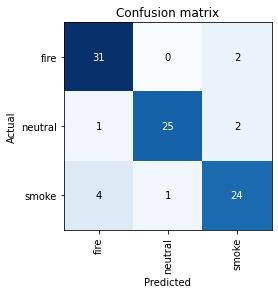

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# About Test Set

Test set contains 20 images. You can change the index number (idx) to see how the model performs on different images.

fire 99.2432 %


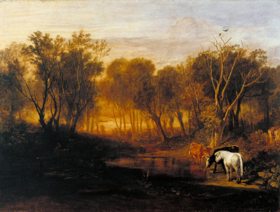

In [ ]:
imgs = get_image_files("/content/drive/MyDrive/test", recurse=False)

idx = 0
prediction = learn.predict(imgs[idx])

print("{} {:.4f} %".format(prediction[0], 100*max(prediction[2])))
Image.open(imgs[idx]).to_thumb(280,280)

It still misclassifies red background images as fire. To fix this problem, we can add more red tone images which are not fire into neutral folder.

I have tried to increase number of epochs but it caused overfitting(the difference between validation loss and training loss growed fastly). 

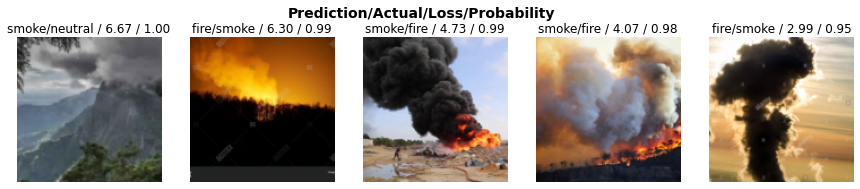

In [ ]:
# I solved missing figure issue with the method that Mehmet Sergen Çatal suggested from :
#                               https://forums.fast.ai/t/plot-top-losses-problem/92015/12

def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)



plot_top_losses_fix(interp, 5, nrows=1)

# Comment on Top Losses


The first image above classified a neutral class image as smoke because of cloud.

In the second image,we can understand there is a fire because of the backroud red tone but it is actually smoke.


In the third and fourth images, smoke is also visible but it is the result of fire. The reason of using this dataset is to see how a deep learning model distinguish these kind of images and as I mentioned above, it is a difficult task for humans too. 

The fifth image is totally a smoke image. Our model took into account sunlight and predicted it as fire.

We can solve these problems by collecting more data. I did not prefer to use data augmentation techniques such as random resize crop. The reason is that some images' features are located in small parts of images and with random crop, these parts can be lost with random cropping.    





# ***Test Examples***

neutral 94.3671 %


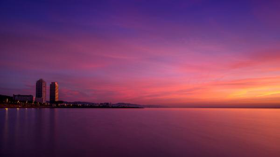

In [ ]:
idx = 20
prediction = learn.predict(imgs[idx])

print("{} {:.4f} %".format(prediction[0], 100*max(prediction[2])))
Image.open(imgs[idx]).to_thumb(280,280)

smoke 99.9164 %


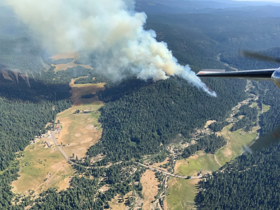

In [ ]:
idx = 7
prediction = learn.predict(imgs[idx])

print("{} {:.4f} %".format(prediction[0], 100*max(prediction[2])))
Image.open(imgs[idx]).to_thumb(280,280)

fire 99.9930 %


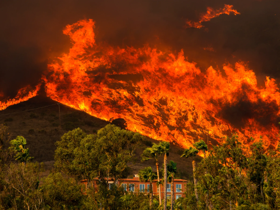

In [ ]:
idx = 12
prediction = learn.predict(imgs[idx])

print("{} {:.4f} %".format(prediction[0], 100*max(prediction[2])))
Image.open(imgs[idx]).to_thumb(280,280)